In [1]:
# This is only needed if the notebook is run in VSCode
import nbs_pipeline.utils.vscode  as vs
vs.DisplayHandle.update = vs.update_patch


# OR-ELM: Online Recurrent Extreme Learning Machine for time-series prediction

> This notebook applies visual analytics to [OR_ELM](https://github.com/chickenbestlover/Online-Recurrent-Extreme-Learning-Machine) algorithm

In [2]:
try:
    from tsai.all import *
except:
    from tsai.all import * # TODO: Weird error when loading tsai!from tchub.all import *
import wandb
wandb_api = wandb.Api()
from fastcore.all import *
from fastai.callback.wandb import WandbCallback
from fastai.callback.schedule import *
from dvats.all import *
import nbs.orelm.orelm_torch as orelm

Initialize loss function
Initialize loss function
Initialize loss function


For the experiment tracking and hyperparameter we will use the tool **Weights & Biases**. 

Before running this notebook, make sure you have the `$WANDB_API_KEY` environment varibale defined with your API_KEY (run in a terminal `echo $WANDB_API_KEY` to see it). If not, run in a terminal `wandb login [API_KEY]`. You can see your API_KEY [here](https://wandb.ai/authorize) or in the settings of your W&B account.

## Notebook configuration

In [3]:
import nbs_pipeline.utils.config as cfg
config, job_type, dataSet = cfg.get_artifact_config_ORELM(True)

Current: /home/macu/work/nbs_pipeline
yml: ./config/02c-encoder_orelm.yaml
... About to replace includes with content
Before configuration reading 
-include: None
-user_preferences:
	-use_wandb: False
	-wdb:
		-user: mi-santamaria
		-project_name: test-project
		-version: 0
		-mode: offline
		-artifacts_path: ./data/wandb_artifacts
	-data:
		-folder: ~/data/
		-fname: speed_6005
		-ftype: .csv
		-cols: [1]
		-freq: 1s
	-artifact:
		-alias: TiltABP
	-directories:
		-tmp: tmp
		-data: ~/data/speed_6005.csv
-data:
	-name: speed_6005
	-path: ~/data/speed_6005.csv
	-alias: TiltABP
	-cols: [1]
	-csv_config:
	-date_offset: None
	-date_format: %Y-%m-%d %H:%M:%S
	-freq: 1s
	-joining_train_test: False
	-missing_values:
		-technique: None
		-constant: None
	-normalize_training: False
	-range_training: None
	-range_testing: None
	-resampling_freq: None
	-start_date: None
	-test_split: None
	-time_col: None
-wandb:
	-user: mi-santamaria
	-dir: ~/test-project
	-enabled: False
	-group: None
	-log_lea

In [4]:
print("Project: "+config.wandb_project)
run = wandb.init(
    entity          = config.wandb_entity,
    project         = config.wandb_project,
    group           = config.wandb_group,
    job_type        = job_type,
    allow_val_change= True,
    mode            = 'online' if config.use_wandb else 'disabled',
    config          = config,
    resume          = False
)
config = run.config  # Object for storing hyperparameters
# Botch to use artifacts offline
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Project: test-project


## Loading the datasets

In [5]:
print("Used dataSet:")
cfg.recursive_print_attrdict(dataSet)

Used dataSet:
-folder: ~/data/
-fname: speed_6005
-ftype: .csv
-cols: [1]
-freq: 1s


### Sliding window features

$Z$ is a $w \times s \times t$ matrix. The first step consists in slicing the original multivariate time series into slices of shape ($w \times d$), as shown in this figure from the paper.
<img src="https://i.imgur.com/R9Fx8uO.png" style="width:800px;height:400px"/>

The hyperparameters of this sliding window approach are given values by default here. If the value has been already set previously, that means this notebook is being called from a wandb sweep, and we must use the value that the sweep is bringing.

In [6]:
print("--- SLIDING WINDOW --")
print("Len: " + str(config.w))
print("Stride: " + str(config.stride))

--- SLIDING WINDOW --
Len: 200
Stride: 1


In [7]:
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])

In [8]:
#get artiffact
train_artifact = artifacts_gettr(config.train_artifact)
#convert to pandas dataset
df_train = train_artifact.to_df()
df_train.head(5)

wandb:   1 of 1 files downloaded.  


,timestamp,value
1970-01-01 00:00:00,2015-08-31 18:22:00,90
1970-01-01 00:00:01,2015-08-31 18:32:00,80
1970-01-01 00:00:02,2015-08-31 18:57:00,84
1970-01-01 00:00:03,2015-08-31 19:07:00,94
1970-01-01 00:00:04,2015-08-31 19:12:00,90


In [9]:
# Subset of variables
if dataSet.cols:
    df_train = df_train.iloc[:, dataSet.cols]
print(f'Num. variables: {len(df_train.columns)}')
df_train.head(5)

Num. variables: 1


,value
1970-01-01 00:00:00,90
1970-01-01 00:00:01,80
1970-01-01 00:00:02,84
1970-01-01 00:00:03,94
1970-01-01 00:00:04,90


In [10]:
df_train

,value
1970-01-01 00:00:00,90
1970-01-01 00:00:01,80
1970-01-01 00:00:02,84
1970-01-01 00:00:03,94
1970-01-01 00:00:04,90
...,...
1970-01-01 00:41:35,81
1970-01-01 00:41:36,89
1970-01-01 00:41:37,87
1970-01-01 00:41:38,82


In [11]:
# standardize data by subtracting mean and dividing by std
meanSeq     = np.mean(df_train['value'])
print(meanSeq)
stdSeq      = np.std(df_train['value'])
print(stdSeq)
df_train['value'] = (df_train['value'] - meanSeq)/stdSeq
df_train.head()

81.9068
8.744856417346142


,value
1970-01-01 00:00:00,0.925481
1970-01-01 00:00:01,-0.218048
1970-01-01 00:00:02,0.239364
1970-01-01 00:00:03,1.382893
1970-01-01 00:00:04,0.925481


In [12]:
#Setup Training windows
X_train, _ = sw(df_train) #Windows
data = {
    "Description": [
        "Dataset shape", 
        "Number of Sliding windows", 
        "Sliding window shape"
    ],
    "Value": [
        str(df_train.shape), 
        str(X_train.shape[0]), 
        f"({X_train.shape[1]}, {X_train.shape[2]})"
    ]
}

training_info = pd.DataFrame(data)
training_info

,Description,Value
0,Dataset shape,"(2500, 1)"
1,Number of Sliding windows,2301
2,Sliding window shape,"(1, 200)"


In [13]:
df_train.head(5)

,value
1970-01-01 00:00:00,0.925481
1970-01-01 00:00:01,-0.218048
1970-01-01 00:00:02,0.239364
1970-01-01 00:00:03,1.382893
1970-01-01 00:00:04,0.925481


In [14]:
if config.valid_artifact:
    valid_artifact = artifacts_gettr(config.valid_artifact)
    df_val = valid_artifact.to_df()
    X_valid, _ = sw(df_val)
    df_val.shape, X_valid.shape
    print("valid_artifact")
    print(valid_artifact)
    print("df_val")
    print(df_val)
    print("X_valid")
    print(X_valid)
    print("df_val.shape")
    print(df_val.shape)
    print("X_valid.shape")
    print(X_valid.shape)
else:
    print("No validation artifact. Random items to get:", config.valid_size)

No validation artifact. Random items to get: 0.1


## TODO: METER EXPLICACIÓN DE OR-ELM


todo: AQUI VA LA EXPLICACIÓN CON EL EJEMPLO QUE SE META EN EL PAPER

### Create the model

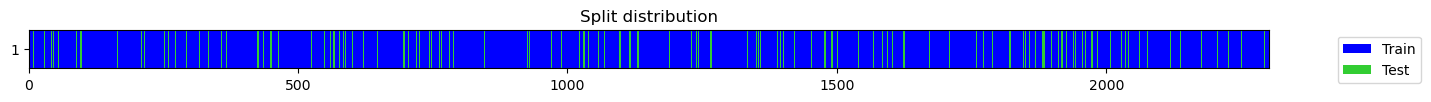

X.shape: (2301, 1, 200)
y.shape: (2301, 1, 200)


In [15]:
#Split dataset
random.seed = config.random_seed
if config.valid_artifact:
    X, y, splits  = combine_split_data(xs=[X_train, X_valid], ys=[X_train, X_valid])
else:
    X = X_train
    y = X_train
    splits = get_splits(np.arange(len(X)), valid_size=config.valid_size)
splits
print("X.shape: "+str(X.shape))
print("y.shape: "+str(y.shape))
#print(splits)

In [16]:
#Create and train the model
#features = pd.DataFrame(dls.dataset[0][0])
#targets = pd.DataFrame(dls.dataset[0][1]) #1

#print("dls len: " + str(len(dls.dataset)))

#print("Features shape: " + str(features.shape))
#print("Targets shape: " + str(features.shape))

#dls.dataset

In [17]:
numLags         = X_train.shape[0] #config.epochs
nDimInput       = numLags
nDimOutput      = 1 #targets.shape[1] #1
numNeurons      = config.numHiddenNeurons #nDimInput  #config.numHiddenNeurons
algorithm       = config.algorithm
LN              = config.LN 
AE              = config.AE
InWeightFF      = config.inputWeightForgettingFactor #1.0
OutWeightFF     = config.outputWeightForgettingFactor #0.92
HiddenWeightFF  = config.inputWeightForgettingFactor #1.0
lamb            = config.lamb
predictionStep  = config.stride #5


In [18]:

data_to_append = {
    "Description": [
        "inputs/Charasteristics", 
        "Targets shape", 
        "X_train shape", 
        "Input Weights", 
        "Hidden Weights", 
        "Hidden A", 
        "Bias", 
        "Features"
    ],
    "Value": [
        str(nDimInput),
        str(y.shape),
        str(X_train.shape),
        f"({numNeurons}, {nDimInput})",
        f"({numNeurons}, {numNeurons})",
        f"({nDimOutput}, {numNeurons})",
        f"({nDimOutput}, {numNeurons})",
        f"({nDimOutput}, {nDimInput})"
    ]
}
data_to_append = pd.DataFrame(data_to_append)
training_info = training_info.append(data_to_append, ignore_index = True)
training_info.head

<bound method NDFrame.head of                   Description           Value
0               Dataset shape       (2500, 1)
1   Number of Sliding windows            2301
2        Sliding window shape        (1, 200)
3      inputs/Charasteristics            2301
4               Targets shape  (2301, 1, 200)
5               X_train shape  (2301, 1, 200)
6               Input Weights      (25, 2301)
7              Hidden Weights        (25, 25)
8                    Hidden A         (1, 25)
9                        Bias         (1, 25)
10                   Features       (1, 2301)>

Train the model with fastai Learner class, to abstract from Pytorch's training loop




To track the performance of this model fit, go to the project dashboard in Weights & Biases. The link is provided at the beginning of this notebook, after the execution of the function `wandb.init()'' 

Finally, log the learner to be used by the next notebook in the pipeline

In [19]:
m = orelm.ORELM_torch(
    inputs                      =   X_train.shape[2], #nDimInput,
    outputs                     =   nDimOutput,
    numHiddenNeurons            =   config.numHiddenNeurons,
    activationFunction          =   config.activationFunction,
    LN                          =   config.LN,
    AE                          =   config.AE,
    ORTH                        =   config.ORTH,
    inputWeightForgettingFactor =   config.inputWeightForgettingFactor,
    outputWeightForgettingFactor=   config.outputWeightForgettingFactor
)
m.initializePhase(lamb=0.0001)
print(m)

inputs: 200
outputs: 1
numNeurons: 25
Out weight FF: 0.92
(25, 200)
Foselm -- before bias
Foselm -- before beta
Foselm -- before bias
Foselm -- before beta
--> Initialize_Phase: Input Weights initialized. Shape: torch.Size([25, 200])
Foselm - initialize phase
Foselm - initialize phase
ORELM_torch(
  (inputAE): FOSELM_torch()
  (hiddenAE): FOSELM_torch()
)


In [20]:
tfms = [ToFloat(), ToFloat()]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)

In [21]:
#Preparando dlstfms = [ToFloat(), ToFloat()]

#DataLoader
print("X_train shape[0]: " + str(X_train.shape[0]))
print("X.shape: "+str(X.shape))
print("y.shape: "+str(y.shape))
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
print("dls.shape: "+str(X.shape))
print("Last dls.shape: "+str(X[-1].shape))
print(len(dls.train))
for batch in dls.train:
    #print("El 0. " + str(batch[0]))
    print("El 1. " + str(batch[1].shape))

X_train shape[0]: 2301
X.shape: (2301, 1, 200)
y.shape: (2301, 1, 200)
dls.shape: (2301, 1, 200)
Last dls.shape: (1, 200)
32
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. torch.Size([64, 1, 200])
El 1. t

In [22]:
#Build learner
learn =  Learner(
    dls         = dls, 
    model       = m, 
    loss_func   = nn.MSELoss(), #
    opt_func    = Adam, #Creates an optimizer
    cbs         = [WandbCallback(log_preds=False)] #List of callbacks
)

print(type(dls))
print(type(m))


Initialize loss function
<class 'tsai.data.core.TSDataLoaders'>
<class 'nbs.orelm.orelm_torch.ORELM_torch'>


In [23]:
print(m)

ORELM_torch(
  (inputAE): FOSELM_torch()
  (hiddenAE): FOSELM_torch()
)


In [24]:
"""
#### Prueba comprobar tamaños para m "en pequeño"
step = 0
predictions = []
target = []
maxStep = X.shape[0]
for i in range(maxStep-1):
    training_dataset = X[i]
    targets = y[i]
    features = X[i+1] 
    print("Training["+str(i)+"] shape: " + str(training_dataset.shape))
    print("Targets["+str(i)+"] shape: " + str(targets.shape))
    m.train(training_dataset, targets)
    Y = m.predict(features)
    predictions.append(Y[0][0])
    target.append(y[i+1][0])
    print (str(step)+"th/"+str(maxStep)+" ("+str(i)+") timeStep of "+str(maxStep) +" -  target: "+str(target[i]) + " |    prediction: "+str(predictions[-1]))
"""

'\n#### Prueba comprobar tamaños para m "en pequeño"\nstep = 0\npredictions = []\ntarget = []\nmaxStep = X.shape[0]\nfor i in range(maxStep-1):\n    training_dataset = X[i]\n    targets = y[i]\n    features = X[i+1] \n    print("Training["+str(i)+"] shape: " + str(training_dataset.shape))\n    print("Targets["+str(i)+"] shape: " + str(targets.shape))\n    m.train(training_dataset, targets)\n    Y = m.predict(features)\n    predictions.append(Y[0][0])\n    target.append(y[i+1][0])\n    print (str(step)+"th/"+str(maxStep)+" ("+str(i)+") timeStep of "+str(maxStep) +" -  target: "+str(target[i]) + " |    prediction: "+str(predictions[-1]))\n'

In [25]:
"""
#print("self.dls shape: " + str(learn.dls.train.shape))
#print("self.dls.train " + str(len(learn.dls.train)))

import sys

# Abre un archivo para redirigir la salida de print
output_file = open('my_logs.txt', 'w')
sys.stdout = output_file

#cprofiler = cProfile.Profile()
lr_valley, lr_steep =   learn.lr_find(
                            suggest_funcs=[valley, steep]
                            )

#lr_valley, lr_steep = learn.lr_finsd(suggest_funcs=[valley, steep]) --> original
#learn.fit_one_cycle(1, lr_max=lr_valley)
#learn.fit_one_cycle(config.epochs, lr_max=lr_valley)
#learn.plot_metrics()
"""

'\n#print("self.dls shape: " + str(learn.dls.train.shape))\n#print("self.dls.train " + str(len(learn.dls.train)))\n\nimport sys\n\n# Abre un archivo para redirigir la salida de print\noutput_file = open(\'my_logs.txt\', \'w\')\nsys.stdout = output_file\n\n#cprofiler = cProfile.Profile()\nlr_valley, lr_steep =   learn.lr_find(\n                            suggest_funcs=[valley, steep]\n                            )\n\n#lr_valley, lr_steep = learn.lr_finsd(suggest_funcs=[valley, steep]) --> original\n#learn.fit_one_cycle(1, lr_max=lr_valley)\n#learn.fit_one_cycle(config.epochs, lr_max=lr_valley)\n#learn.plot_metrics()\n'

In [26]:
#output_file.close()


In [27]:
"""
import pstats

# Genera el informe de perfil
informe_perfil = pstats.Stats(cprofiler)
informe_perfil.strip_dirs()  # Elimina información de directorios
informe_perfil.sort_stats('cumulative')  # Ordena por tiempo acumulativo
informe_perfil.print_stats()  # Imprime el informe
""" 

"\nimport pstats\n\n# Genera el informe de perfil\ninforme_perfil = pstats.Stats(cprofiler)\ninforme_perfil.strip_dirs()  # Elimina información de directorios\ninforme_perfil.sort_stats('cumulative')  # Ordena por tiempo acumulativo\ninforme_perfil.print_stats()  # Imprime el informe\n"

In [28]:
print("Prediction Step: " + str(predictionStep))
#X = np.array([X[w][0] for w in range(X_train.shape[0])]).T
#T = np.array([y[w][0] for w in range(X_train.shape[0])]).T   
#T = np.array([y[w][0][predictionStep] for w in range(X_train.shape[0])]).T   

def getTimeEmbeddedMatrix(sequence, numLags=100, predictionStep=1, inDim=100, outDim = 1):
  print("Generate time embedded matrix")
  print("inDim ="+ str(inDim))
  print("outDim ="+ str(outDim))
  #total = len(sequence)
  total = X_train.shape[2]
  X = np.zeros(shape=(total, inDim))
  T = np.zeros(shape=(total, outDim))
  print("X.shape " + str(X.shape))
  print("T.shape " + str(T.shape))
  for i in range(numLags-1, total-predictionStep):
    X[i, :] = np.array(sequence[(i-numLags+1):(i+1)])
    T[i, :] = sequence[i+predictionStep]
  return (X, T)

(X, T) = getTimeEmbeddedMatrix(X_train[0], numLags, predictionStep, nDimInput, nDimOutput)
print("X_train ~ ", str(X_train.shape))
print('Input shape: ', str(X.shape))
print('Target shape: ', str(T.shape))

Prediction Step: 1
Generate time embedded matrix
inDim =2301
outDim =1
X.shape (200, 2301)
T.shape (200, 1)
X_train ~  (2301, 1, 200)
Input shape:  (200, 2301)
Target shape:  (200, 1)


In [29]:
predictions = []
target = []
maxStep = X.shape[0]-predictionStep-1
print("Num steps: " + str(maxStep))

Num steps: 198


In [31]:
step = 0
for i in range(1):
    training_dataset = torch.from_numpy(X[[i],:]).float()
    targets = torch.from_numpy(T[[i],:]).float()
    features = torch.from_numpy(X[[i+1],:]).float()
    print("Training["+str(i)+"] shape: " + str(training_dataset.shape))
    print("Targets["+str(i)+"] shape: " + str(targets.shape))
    print("Features["+str(i)+"] shape: " + str(features.shape))
    m.train_func(training_dataset, targets)
    Y = m.predict(features)
    predictions.append(Y[0][0])
    target.append(T[i][0])
    print (str(step)+"th/"+str(maxStep)+" ("+str(i)+") timeStep of "+str(maxStep) +" -  target: "+str(target[i]) + " |    prediction: "+str(predictions[-1]))

Training[0] shape: torch.Size([1, 2301])
Targets[0] shape: torch.Size([1, 1])
Features[0] shape: torch.Size([1, 2301])
ORELM:TRAIN:samples = weights: 1 | outputs: 1
ORELM:TRAIN:Features shape: torch.Size([1, 2301])=> Columns: 1
ORELM:TRAIN:Weights number: 1 = 1
--> Calculate Hidden Activation 1
--> Foselm: Train
targets shape torch.Size([1, 2301])
FOSELM:TRAIN:2SHAPED
Check if a better partition can be done: last window has just 2301 inputs instead of 200
FOSELM:Train:END -->
--> Foselm: Train
targets shape torch.Size([1, 25])
FOSELM:TRAIN:2SHAPED
Dimensions ok
Features ~ torch.Size([1, 25])
Targets ~ torch.Size([1, 25])
Inputs ~ 25
1 1
--> Train func (single)
Foselm - Calculate Hidden layer activation
Features: torch.Size([1, 25])
weights: torch.Size([25, 25])
Foselm - Layer normalizatison
--> SigmoidActFunc V ~ torch.Size([1, 25])
SigmoidActFunc -->
FOSELM: Calculate hidden layer activation -->
non RLS
Train func (single) -->
FOSELM:Train:END -->
Before LR 1: torch.Size([1, 2301])
--

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2301 and 200x25)

# Evaluation: Calculate total Normalizedd Root Mean Square Error (NRMSE)

In [ ]:
# Reconstruct original value
predictions = np.array(predictions)
target = np.array(target)
predictions = predictions * stdSeq + meanSeq
target = target * stdSeq + meanSeq
  
def computeSquareDeviation(predictions, truth):
  squareDeviation = np.square(predictions-truth)
  return squareDeviation

# Calculate NRMSE from skip_eval to the end
skip_eval=100
squareDeviation = computeSquareDeviation(predictions, target)
squareDeviation[:skip_eval] = None
nrmse = np.sqrt(np.nanmean(squareDeviation)) / np.nanstd(predictions)
print("NRMSE {}".format(nrmse))

In [ ]:
print("Target len: " + str(len(target)) + str(target))
print("Prediction len: " + str(len(predictions))+str(predictions))

## Plot predictions and target values

In [ ]:

algorithm = config.algorithm
print(algorithm)
print(config.job_type)
plt.figure(figsize=(15,6))

targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
plt.xlim([0, 200])
plt.ylim([60, 100])
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of '+ config.job_type + ' algorithm: ' + algorithm +' on '+dataSet.fname+' dataset' ,fontsize=20,fontweight=40)
plot_path = './predictionPlot.png'
#plt.savefig(plot_path,plot_pathbbox_inches='tight')
plt.savefig(plot_path,bbox_inches='tight')
plt.draw()
plt.show()
plt.pause(0)
print('Prediction plot is saved to'+plot_path)

## Online learning and prediction of OR-ELM

In [ ]:
run.finish()